In [32]:

import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import string

In [33]:
import wikipediaapi
import re
from sentence_splitter import SentenceSplitter

In [34]:
wiki_wiki = wikipediaapi.Wikipedia('Finding k', 'en')

wiki_py = wiki_wiki.page("Pac-Man")

corpus_txt = ""
nr_used_sections = 0

def get_sections(sections, level=0):
    global nr_used_sections
    global corpus_txt
    for s in sections:
        if s.title.lower() not in ["references", "external links", "further reading", "notes"]:
            print(s.title)
            corpus_txt += s.text
            nr_used_sections += 1
        get_sections(s.sections, level + 1)

get_sections(wiki_py.sections)


Gameplay
Development
Release
Ports
Reception
Commercial performance
Accolades
Impact
Reviews
Legacy
Merchandise
Television
Literature
Music
Film
Other gaming media
Perfect scores and other records
Remakes and sequels
Technology


In [35]:
splitter = SentenceSplitter("en")

In [36]:
# check if corpus_data folder exists, if not, create it
import os
folder = "./corpus_data/"
if not os.path.exists(folder):
    os.makedirs(folder)

# check if corpus_data folder is empty, if not, create the corpus data files
# PLEASE NOTICE: if the folder is not empty, the no files will be written
# Sometimes it might be good idea, to delete the "corpus_data" folder...
if len(os.listdir(folder)) == 0:
    for i, sent in enumerate(splitter.split(corpus_txt)):
        with open(folder+f'pacman_{i+1}.txt', 'w', encoding="utf-8") as f:
            f.write(sent)
            

In [37]:
original_corpus = []
folder = "./corpus_data/"
files = []
for filename in os.listdir(folder):
    files.append(filename)

nr_files = len(files)

for i in range(nr_files):
    with open(folder+f'pacman_{i+1}.txt', "r", encoding="utf-8") as f:
        original_corpus.extend(f.readlines())

In [38]:
nr_used_sections

19

In [39]:
ts = 2  # the number of topics to start with 2
te = nr_used_sections * 2 + 1 # maximum number of topics to end with

In [40]:
from tmtoolkit.corpus import filter_for_pos
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import Corpus, print_summary

In [41]:
from copy import copy
corpus = Corpus.from_folder(folder, language='en')
crp = copy(corpus)
print_summary(crp)

Corpus with 194 documents in English
> pacman_10 (11 tokens): Eating multiple blue ghosts in succession increase...
> pacman_100 (26 tokens): The number of arcade units sold had tripled to 400...
> pacman_103 (52 tokens): Pac - Man and Ms. Pac - Man also topped the US ReP...
> pacman_107 (17 tokens): Pac - Man also won the Video Software Dealers Asso...
> pacman_104 (122 tokens): In addition , Coleco 's tabletop mini - arcade uni...
> pacman_102 (45 tokens): Pac - Man is the best - selling arcade game of all...
> pacman_1 (22 tokens): Pac - Man is an action maze chase video game ; the...
> pacman_105 (32 tokens): II Computing also listed the Atarisoft port tenth ...
> pacman_106 (42 tokens): As of 2016 , all versions of Pac - Man are estimat...
> pacman_101 (30 tokens): In a 1983 interview , Nakamura said that though he...
(and 184 more documents)
total number of tokens: 7038 / vocabulary size: 1826


In [42]:
from tmtoolkit.corpus import lemmatize, to_lowercase, remove_punctuation, filter_clean_tokens

In [43]:
filter_clean_tokens(crp, remove_shorter_than=2, remove_numbers=True, remove_punct=True, remove_stopwords=True)
to_lowercase(crp)
lemmatize(crp)
print_summary(crp)

Corpus with 194 documents in English
> pacman_10 (8 tokens): eat multiple blue ghost succession increase point ...
> pacman_100 (9 tokens): number arcade unit sell triple receive estimate to...
> pacman_103 (25 tokens): Pac Man Ms. Pac Man top RePlay cocktail arcade cab...
> pacman_107 (11 tokens): Pac Man win Video Software Dealers Association VSD...
> pacman_104 (58 tokens): addition Coleco tabletop mini arcade unit sell uni...
> pacman_102 (20 tokens): Pac Man well sell arcade game time surpass Space I...
> pacman_1 (13 tokens): Pac Man action maze chase video game player contro...
> pacman_105 (16 tokens): II Computing list Atarisoft port magazine list App...
> pacman_106 (16 tokens): version Pac Man estimate gross total revenue Pac M...
> pacman_101 (9 tokens): interview Nakamura say expect Pac Man successful t...
(and 184 more documents)
total number of tokens: 3312 / vocabulary size: 1322


In [44]:
dtm_, doc_labels, vocab = dtm(crp, return_doc_labels=True, return_vocab=True)

In [45]:
# this isn't the best way to do this, but it works for now :-)
top_n = int(0.01 * dtm_.shape[1])
top_n

13

In [46]:
%%time
import tmtoolkit
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'n_iter': 1000,
    'random_state': 42,  # to make results reproducible
    'eta': 0.1,                # sometimes also called "beta"
}

# iterate with different LDA models with different number of topics
var_params = [{'n_topics': k, 'alpha': 1.0/k}
               for k in range(ts, te, 1)]

eval_results = evaluate_topic_models(dtm_,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=top_n,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True)

CPU times: total: 62.5 ms
Wall time: 24.5 s


In [47]:
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.visualize import plot_eval_results

c:\Users\marju\anaconda3\envs\Py310\lib\site-packages\tmtoolkit\topicmod\visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

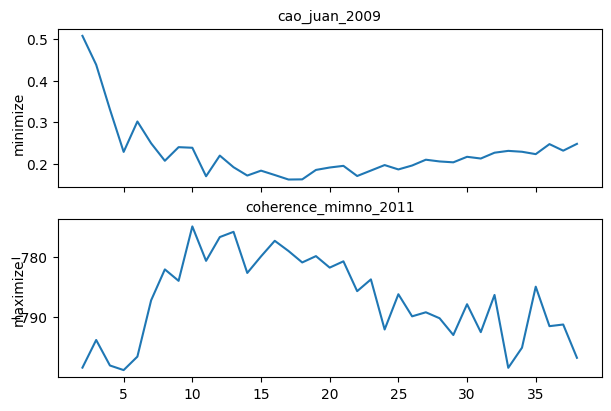

In [48]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
plot_eval_results(eval_results_by_topics)

In [49]:
# min value represents the best number of topics
df_cao = pd.DataFrame(results_by_parameter(eval_results, "n_topics", "cao_juan_2009"))
df_cao

,0,1
0,17,"{'model': <lda.lda.LDA object at 0x0000014963086C50>, 'cao_juan_2009': 0.1620615252619857, 'coherence_mimno_2011': -779.0829889635004}"
1,18,"{'model': <lda.lda.LDA object at 0x0000014963086D10>, 'cao_juan_2009': 0.16244031064061012, 'coherence_mimno_2011': -780.9779030651008}"
2,11,"{'model': <lda.lda.LDA object at 0x00000149630867D0>, 'cao_juan_2009': 0.16993032920254586, 'coherence_mimno_2011': -780.7133294671365}"
3,22,"{'model': <lda.lda.LDA object at 0x0000014963086F20>, 'cao_juan_2009': 0.17053624172036483, 'coherence_mimno_2011': -785.7273041968757}"
4,14,"{'model': <lda.lda.LDA object at 0x00000149630868F0>, 'cao_juan_2009': 0.17164820868565403, 'coherence_mimno_2011': -782.7146453253872}"
5,16,"{'model': <lda.lda.LDA object at 0x0000014963086B30>, 'cao_juan_2009': 0.17293046690963326, 'coherence_mimno_2011': -777.3981032716345}"
6,15,"{'model': <lda.lda.LDA object at 0x0000014963086B00>, 'cao_juan_2009': 0.1834383160993537, 'coherence_mimno_2011': -779.9774018012993}"
7,23,"{'model': <lda.lda.LDA object at 0x0000014963086FE0>, 'cao_juan_2009': 0.18368946441111142, 'coherence_mimno_2011': -783.7799336780021}"
8,19,"{'model': <lda.lda.LDA object at 0x0000014963086DA0>, 'cao_juan_2009': 0.18517714958070458, 'coherence_mimno_2011': -779.9310550992542}"
9,25,"{'model': <lda.lda.LDA object at 0x00000149630870A0>, 'cao_juan_2009': 0.1863725374265211, 'coherence_mimno_2011': -786.2337722518004}"


In [50]:

# the greatest value represents the best number of topics (the highest coherence) and is at the end of the list
df_mimno = pd.DataFrame(results_by_parameter(eval_results, "n_topics", "coherence_mimno_2011"), columns=["n_topics", "model"])
df_mimno

,n_topics,model
0,5,"{'model': <lda.lda.LDA object at 0x00000149630864D0>, 'cao_juan_2009': 0.22861128131102984, 'coherence_mimno_2011': -798.7780370859621}"
1,33,"{'model': <lda.lda.LDA object at 0x0000014963087460>, 'cao_juan_2009': 0.23108238143963997, 'coherence_mimno_2011': -798.4009558328738}"
2,2,"{'model': <lda.lda.LDA object at 0x0000014963086380>, 'cao_juan_2009': 0.5081696092685009, 'coherence_mimno_2011': -798.3712316123076}"
3,4,"{'model': <lda.lda.LDA object at 0x00000149630864A0>, 'cao_juan_2009': 0.33102694619665657, 'coherence_mimno_2011': -798.0163447424916}"
4,38,"{'model': <lda.lda.LDA object at 0x00000149630878B0>, 'cao_juan_2009': 0.24798322682647245, 'coherence_mimno_2011': -796.7461140472645}"
5,6,"{'model': <lda.lda.LDA object at 0x00000149630865F0>, 'cao_juan_2009': 0.30186660552712813, 'coherence_mimno_2011': -796.54866614313}"
6,34,"{'model': <lda.lda.LDA object at 0x00000149630876D0>, 'cao_juan_2009': 0.22893263683419074, 'coherence_mimno_2011': -795.074063412314}"
7,3,"{'model': <lda.lda.LDA object at 0x00000149630863E0>, 'cao_juan_2009': 0.4385637920414418, 'coherence_mimno_2011': -793.7982157099735}"
8,29,"{'model': <lda.lda.LDA object at 0x0000014963086F50>, 'cao_juan_2009': 0.20349006534376257, 'coherence_mimno_2011': -792.9770026402662}"
9,31,"{'model': <lda.lda.LDA object at 0x0000014963087400>, 'cao_juan_2009': 0.21265888458084517, 'coherence_mimno_2011': -792.5020646388487}"


In [51]:
dtm_, vocab = dtm(crp, return_doc_labels=False, return_vocab=True)

In [52]:
# get the best model according to Cao Juan (2009)
results = []
for k, res in eval_results:
    results.append((k, res))

mimno_scores = [res['coherence_mimno_2011'] for k, res in results]
best_mimno_k = results[np.argmax(mimno_scores)][0]
best_mimno_k

{'n_topics': 10, 'alpha': 0.1, 'n_iter': 1000, 'random_state': 42, 'eta': 0.1}

In [53]:
best_mimno_lda = results[np.argmax(mimno_scores)][1]['model']
best_mimno_lda.n_topics

10

In [54]:
# get the best model according to Cao Juan (2009)
results_cao = []
for k, res in eval_results:
    results_cao.append((k, res))

cao_scores = [res['cao_juan_2009'] for k, res in results_cao]
best_cao_k = results[np.argmin(cao_scores)][0]
best_cao_k

{'n_topics': 17,
 'alpha': 0.058823529411764705,
 'n_iter': 1000,
 'random_state': 42,
 'eta': 0.1}

In [55]:
best_cao_lda = results[np.argmin(cao_scores)][1]['model']
best_cao_lda.n_topics

17

In [56]:
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words

In [57]:
print_ldamodel_topic_words(best_mimno_lda.topic_word_, vocab, top_n=4)

topic_1
> #1. Man (0.055171)
> #2. Pac (0.051099)
> #3. game (0.032777)
> #4. series (0.020562)
topic_2
> #1. Pac (0.116179)
> #2. Man (0.097107)
> #3. sell (0.039892)
> #4. game (0.027177)
topic_3
> #1. sprite (0.032343)
> #2. time (0.029429)
> #3. color (0.029429)
> #4. list (0.014860)
topic_4
> #1. game (0.098514)
> #2. video (0.038591)
> #3. Namco (0.019415)
> #4. create (0.019415)
topic_5
> #1. ghost (0.042238)
> #2. Man (0.035604)
> #3. Pac (0.031181)
> #4. eat (0.024547)
topic_6
> #1. game (0.037536)
> #2. Iwatani (0.031315)
> #3. ghost (0.023019)
> #4. character (0.014724)
topic_7
> #1. release (0.053615)
> #2. version (0.051189)
> #3. Atari (0.043911)
> #4. Famicom (0.017225)
topic_8
> #1. Pac (0.062113)
> #2. Man (0.058672)
> #3. Namco (0.048348)
> #4. release (0.034584)
topic_9
> #1. game (0.046460)
> #2. character (0.042438)
> #3. Man (0.040426)
> #4. Pac (0.034393)
topic_10
> #1. score (0.030774)
> #2. level (0.021633)
> #3. Mitchell (0.015539)
> #4. perfect (0.015539)


In [58]:
print_ldamodel_topic_words(best_cao_lda.topic_word_, vocab, top_n=4)

topic_1
> #1. title (0.020885)
> #2. original (0.020885)
> #3. ghost (0.016790)
> #4. time (0.012695)
topic_2
> #1. game (0.080258)
> #2. player (0.024908)
> #3. success (0.021833)
> #4. release (0.021833)
topic_3
> #1. release (0.074710)
> #2. version (0.056084)
> #3. Namco (0.045737)
> #4. Atari (0.027111)
topic_4
> #1. Man (0.065659)
> #2. Pac (0.065659)
> #3. arcade (0.045352)
> #4. sell (0.045352)
topic_5
> #1. ghost (0.048175)
> #2. eat (0.036206)
> #3. point (0.021245)
> #4. blue (0.021245)
topic_6
> #1. sprite (0.043326)
> #2. color (0.035519)
> #3. kbyte (0.016003)
> #4. pixel (0.016003)
topic_7
> #1. game (0.077614)
> #2. Man (0.074094)
> #3. Pac (0.072334)
> #4. character (0.047694)
topic_8
> #1. Pac (0.142977)
> #2. Man (0.122816)
> #3. include (0.037130)
> #4. game (0.033770)
topic_9
> #1. Man (0.030428)
> #2. Blinky (0.026672)
> #3. Pac (0.019159)
> #4. ghost (0.019159)
topic_10
> #1. Atari (0.022849)
> #2. II (0.018369)
> #3. Munchkin (0.013889)
> #4. Philips (0.009409)


In [59]:
topic_nums1 = []

topic_results = best_mimno_lda.transform(dtm_)
for topic_dist in topic_results:
    topic_num = topic_dist.argmax()
    topic_nums1.append(topic_num)
print("Topic numbers:", topic_nums1)

Topic numbers: [8, 4, 1, 5, 1, 1, 1, 2, 1, 1, 8, 0, 4, 1, 3, 8, 4, 8, 8, 6, 6, 7, 6, 4, 1, 7, 6, 6, 0, 0, 0, 0, 9, 8, 8, 5, 0, 0, 8, 8, 1, 1, 5, 1, 4, 5, 1, 0, 1, 8, 8, 5, 4, 8, 5, 0, 5, 5, 5, 0, 0, 0, 0, 0, 4, 4, 4, 3, 4, 9, 9, 9, 9, 9, 8, 9, 0, 1, 3, 8, 1, 1, 1, 0, 0, 1, 7, 1, 7, 9, 7, 7, 7, 7, 7, 7, 2, 2, 2, 3, 3, 2, 2, 9, 2, 2, 4, 5, 8, 5, 5, 5, 3, 5, 5, 2, 5, 4, 8, 2, 5, 5, 5, 4, 5, 3, 4, 4, 4, 4, 5, 5, 8, 0, 8, 4, 7, 0, 7, 4, 7, 7, 6, 5, 8, 6, 6, 6, 6, 6, 4, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 4, 7, 1, 7, 7, 7, 7, 5, 5, 8, 1, 4, 1, 1, 3, 9, 1, 5, 1, 2, 8, 1]


In [60]:
# print topics
print("=== TOPICS WITH MIMNO (2011) metric ===")
for t in range(best_mimno_lda.n_topics):
    print(f"\n=== TOPIC {t+1} ===\n")
    for i, k in enumerate(topic_nums1):
        if k == t:
            print(original_corpus[i])

=== TOPICS WITH MIMNO (2011) metric ===

=== TOPIC 1 ===

Eating a certain number of dots in a level will cause a bonus item usually in the form of a fruit to appear underneath the center box; the item can be eaten for bonus points.
The idea for energizers was a concept Iwatani borrowed from Popeye the Sailor, a cartoon character that temporarily acquires superhuman strength after eating a can of spinach; it is also believed that Iwatani was also partly inspired by a Japanese children's story about a creature that protected children from monsters by devouring them.
Frank Fogleman, the co-founder of Gremlin Industries, believes that the maze-chase gameplay of Pac-Man was inspired by Sega's Head On 1979, a similar arcade game that was popular in Japan.Iwatani has often claimed that the character of Pac-Man himself was designed after the shape of a pizza with a missing slice while he was at lunch; in a 1986 interview he said that this was only half-truth, and that the Pac-Man character wa

In [61]:
topic_nums2 = []

topic_results = best_cao_lda.transform(dtm_)
for topic_dist in topic_results:
    topic_num = topic_dist.argmax()
    topic_nums2.append(topic_num)
print("Topic numbers:", topic_nums2)

Topic numbers: [6, 4, 3, 13, 3, 3, 2, 9, 3, 3, 6, 6, 4, 6, 6, 6, 8, 6, 6, 13, 9, 7, 9, 4, 7, 8, 12, 2, 10, 10, 10, 10, 7, 6, 6, 16, 10, 6, 6, 6, 7, 7, 15, 7, 8, 0, 15, 3, 3, 15, 6, 6, 6, 16, 16, 7, 5, 12, 6, 6, 6, 3, 14, 6, 4, 7, 4, 0, 4, 4, 11, 11, 11, 11, 10, 11, 11, 7, 12, 1, 3, 7, 7, 3, 3, 7, 7, 7, 7, 16, 7, 7, 7, 7, 12, 7, 12, 5, 12, 12, 12, 5, 5, 16, 5, 5, 8, 15, 6, 13, 13, 14, 14, 15, 1, 5, 16, 4, 6, 4, 6, 15, 6, 13, 16, 16, 8, 6, 4, 8, 15, 4, 14, 9, 1, 2, 0, 13, 7, 8, 7, 2, 2, 13, 3, 9, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 7, 7, 7, 2, 2, 7, 12, 1, 7, 3, 4, 6, 7, 7, 7, 7, 2, 1, 13, 1, 3, 4, 3, 3, 1, 1, 3, 9, 3, 1, 1, 3]


In [62]:
# print topics
print("=== TOPICS WITH CAO JUAN (2009) metric ===")
for t in range(best_cao_lda.n_topics):
    print(f"\n=== TOPIC {t+1} ===\n")
    for i, k in enumerate(topic_nums2):
        if k == t:
            print(original_corpus[i])

=== TOPICS WITH CAO JUAN (2009) metric ===

=== TOPIC 1 ===

Before showing the game to distributors, Namco America made a number of changes, such as altering the names of the ghosts.
The NES version was released for the Wii Virtual Console in 2007.
This has included, among other things, collectible Slurpee Big Gulp cups.

=== TOPIC 2 ===

A similar cabinet was released in 2005 that featured Pac-Man as the centerpiece.
Pac-Man was one of the first popular non-shooting action games, defining key elements of the genre such as "parallel visual processing" which requires simultaneously keeping track of multiple entities, including the player's location, the enemies, and the energizers."Maze chase" games exploded on home computers after the release of Pac-Man.
By 1982, Midway had about 95-105 licensees selling Pac-Man merchandise, including major companies, such as ATT selling a Pac-Man telephone.
The character's gender was changed to female in response to Pac-Man's popularity with women, w